In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import dataset
import random

#num of image channel
num_channels = 3
#image size
img_size = 150
# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels
# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)
#convolutional layer 1

filter_size1 = 10
num_filters1 = 128
#convolutional layer 2
filter_size2 = 5
num_filters2 = 64
#convolutional layer 3
filter_size3 = 5
num_filters3 = 32
#convolutional layer 4
filter_size4 = 5
num_filters4 = 32
#convolutional layer 5
filter_size5 = 5
num_filters5 = 32
#fully connected layer
fc_size = 128

# class info
classes = ['ayam_bakar', 'ayam_crispy', 'bakso', 'gado2', 'ikan_bakar', 'mie_goreng', 'nasi_goreng', 'pecel_lele', 'pizza', 'rendang', 'sate', 'soto', 'sushi']
num_classes = len(classes)


In [2]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features


def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer


x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)
layer_conv4, weights_conv4 = \
    new_conv_layer(input=layer_conv3,
                   num_input_channels=num_filters3,
                   filter_size=filter_size4,
                   num_filters=num_filters4,
                   use_pooling=True)
layer_conv5, weights_conv5 = \
    new_conv_layer(input=layer_conv4,
                   num_input_channels=num_filters4,
                   filter_size=filter_size5,
                   num_filters=num_filters5,
                   use_pooling=True)

layer_flat, num_features = flatten_layer(layer_conv5)
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [3]:
saver = tf.train.Saver()
session = tf.Session()
save_path = 'food_model2/food_model2'
#session.run(tf.global_variables_initializer())
saver.restore(sess=session, save_path=save_path)

[12]


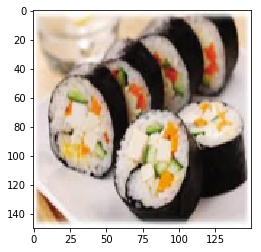

In [4]:
image = cv2.imread('/home/fatchur/food_images/sushi/sushi (3).jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (150, 150), cv2.INTER_LINEAR)
image = np.array(image)
input_image = image.reshape(1, 150*150*3)
feed_dict = {x: input_image}
hasil = y_pred_cls.eval(session = session, feed_dict = feed_dict)
print hasil
plt.imshow(image)
plt.show()